In [2]:
import numpy as np
import pandas as pd
import csv as cv
import os
import matplotlib.pyplot as plt
import re
import csv
import time
import pandas as pd
from random import randint
from scipy.signal import correlate
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn import linear_model
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
import warnings
warnings.filterwarnings('ignore')

In [12]:
path_G_age ="Age_adjustable/"
path_G_crude = "Crude_prevalence/"
path_trends = "trends/"
path_obs = "trends/Data_all/"

In [15]:
list_years = ["2011", "2012", "2013", "2014", "2015", "2016"]
#this part we get specific ground truth data
def data_aggregator(path):
    df_list = []
    for year in list_years:
        g_data = pd.read_csv(path+str(year)+".csv")
        g_data = g_data[(g_data["LocationAbbr"] != "US") & (g_data["LocationAbbr"] != "UW")]
        g_data = g_data[["LocationDesc", "Data_Value"]].dropna()
        g_data = g_data.rename(columns = {"Data_Value":year})
        g_data = g_data.set_index("LocationDesc")
        df_list.append(g_data)      
    result = pd.concat(df_list, axis = 1)
    result.columns = list_years
    return result.transpose()


data_aggregator(path_G_age).head(3)

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2011,21.1,16.5,17.3,22.9,12.1,17.3,15.2,14.2,16.0,16.3,...,18.9,16.4,21.9,23.0,NaN,13.9,19.5,20.1,14.6,18.9
2012,21.6,16.6,18.8,22.2,11.5,17.1,16.6,14.6,16.3,17.0,...,19.6,15.3,20.8,22.2,NaN,16.5,22.2,20.9,16.1,17.8
2013,21.4,16.1,17.9,23.2,12.9,18.0,17.2,17.6,20.8,16.7,...,19.0,15.9,21.8,23.1,NaN,16.3,23.4,22.0,18.1,18.7


In [14]:
series_data_crude = data_aggregator(path_G_crude)
series_data_crude.to_csv(path_G_crude+"series_data_crude.csv")
series_data_adjustable = data_aggregator(path_G_age)
series_data_adjustable.to_csv(path_G_age+"series_data_adjustable.csv")
series_data_adjustable.head(3)

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2011,21.1,16.5,17.3,22.9,12.1,17.3,15.2,14.2,16.0,16.3,...,18.9,16.4,21.9,23.0,NaN,13.9,19.5,20.1,14.6,18.9
2012,21.6,16.6,18.8,22.2,11.5,17.1,16.6,14.6,16.3,17.0,...,19.6,15.3,20.8,22.2,NaN,16.5,22.2,20.9,16.1,17.8
2013,21.4,16.1,17.9,23.2,12.9,18.0,17.2,17.6,20.8,16.7,...,19.0,15.9,21.8,23.1,NaN,16.3,23.4,22.0,18.1,18.7


Getting google trends data using different key words related to our disease under study

In [408]:
keywords = ['misunderstanding', 'tragic', 'oppressed', 'solitary','paranoid','insecure', 'counsel', 'tragedy',
            'cruel', 'overcome', 'suicidal','inability', 'fight', 'tearful', 'injured', 'monitor', 'unhappy', 
            'catatonic', 'prevent','fatigue','talking', 'uncertain', 'unfulfilled', 'gloomy', 'broken', 'shattered',
            'empty', 'low', 'need', 'donut', 'anxiety', 'sorrow', 'progress', 'esteem','inactivity','studies', 
            'sad', 'fatigued', 'unloved', 'melancholia', 'withdrawn', 'patience', 'crying','die', 'blase',
            'exhausted', 'insomnia', 'vulnerable', 'drugs', 'sleep', 'melancholy', 'desperate', 'anxious', 
            'protect', 'fast food', 'death', 'opinion', 'suicide', 'rejected', 'health', 'breakdown','irritable',
            'fear', 'disinterest','withdrawal', 'caregiver', 'inadequate','consumed', 'wounded', 'education',
            'unconcerned','abandoned', 'dreadful', 'problem', 'amenorrhea', 'miserable', 'weight loss', 'excluded',
            'family', 'negative','grouchy', 'troubled', 'distressed','distractable', 'low sex drive', 'weak',
            'morbid','uncooperative', 'sport', 'mental health', 'dejected', 'inconsolable', 'nightmarish', 
            'freaking','mental', 'suffer','endure', 'diet', 'pessimism', 'poor', 'knowledgeable', 'resulting',
            'confusion', 'crisis', 'hurt', 'irritability', 'hot-line','antisocial', 'youth', 'lousy', 'weepy',
            'abnormal', 'desolate', 'alone', 'lonely', 'agitated', 'unsettling', 'sadness', 'kill', 'attitude', 
            'discrimination','hopelessness', 'forlorn', 'warning', 'grief','moody', 'oncoming', 'heal', 
            'distracted', 'anguish', 'substance abuse','fatalistic', 'devastated', 'suffering', 'obesity', 
            'fat', 'gain', 'woeful', 'patient', 'finality','isolation','panic','debilitating', 'tired', 'trajectory', 
            'wretched',  'defeated', 'uneasy', 'wailing', 'nervous', 'nothing', 'scared', 'anger', 'burger',
            'sorrowful','improvement', 'treatment', 'worthless', 'failed', 'separation','psychiatrist','detriment',
            'evaluation', 'abnormal','appetite loss','peers', 'upset', 'needy', 'abuse', 'interested', 'clinical', 
            'down', 'skills','irrational', 'disheartened', 'sympathetic', 'friends', 'level', 'antidepressant', 
            'medication', 'physician', 'pattern', 'disorder', 'worry', 'therapy', 'reckless','crushed', 'strength',
            'distraught','courage', 'despondent', 'pessimistic', 'depressed', 'isolated', 'struggle', 'dismal', 
            'seriousness', 'siblings', 'depression', 'fragile', 'terrified', 'child', 'feelings', 'discontented',
            'afraid', 'aid','validation', 'trapped', 'despair', 'help', 'pain', 'overeating', 'observation', 
            'grieving', 'uncomfortable','agony', 'unpredictable', 'affect', 'dog days', 'demoralized', 'media',
            'talk', 'alienation', 'diagnosis', 'drinking', 'alcohol','melancholy', 'sorrow', 'woeful', 'despondent',
            'dreadful', 'downhearted', 'misery', 'reactive', 'melancholia', 'upset']
keywords = sorted(keywords)
date = ["2011-01-01 2011-12-31", "2012-01-01 2012-12-31", "2013-01-01 2013-12-31", "2014-01-01 2014-12-31", 
        "2015-01-01 2015-12-31", "2016-01-01 2016-12-31"]
len(keywords)

236

Code to get Google trends data using different keywords that are synonym somehow to the disease(Depression in our case) under study. We have considered alot of words which we think relates more to the disease, however, we will later check for correlations with the goundtruth data either crude data or age adjustable data from CDC.

In [409]:

''''

from pytrends.request import TrendReq
import time

# Login to Google. Only need to run this once, the rest of requests will use the same session.
pytrends = TrendReq()

for key in keywords:
    folder = path_trends+key+"/"
    if not os.path.exists(folder):
         os.makedirs(folder)
    for d in range(len(date)):
        
        df = pytrends.build_payload(kw_list = [key],timeframe =date[d], geo = 'US')
        pytrends.interest_over_time().to_csv(folder+key+"_interest_over_time_"+list_years[d]+".csv")
        pytrends.interest_by_region().to_csv(folder+key+"_interest_by_region_"+list_years[d]+".csv")
print("Done Getting Data")
        
        
'''
        
        
        




'\'\n\nfrom pytrends.request import TrendReq\nimport time\n\n# Login to Google. Only need to run this once, the rest of requests will use the same session.\npytrends = TrendReq()\n\nfor key in keywords:\n    folder = path_trends+key+"/"\n    if not os.path.exists(folder):\n         os.makedirs(folder)\n    for d in range(len(date)):\n        \n        df = pytrends.build_payload(kw_list = [key],timeframe =date[d], geo = \'US\')\n        pytrends.interest_over_time().to_csv(folder+key+"_interest_over_time_"+list_years[d]+".csv")\n        pytrends.interest_by_region().to_csv(folder+key+"_interest_by_region_"+list_years[d]+".csv")\nprint("Done Getting Data")\n        \n        \n'

Code below to integrate data from Google trends and groundtruth data into a single data frame.

In [18]:
def integrate_series(key, year, url):
    df = pd.read_csv(url + key + "/"
                     +key+ "_interest_by_region_"+str(year)+".csv")
    df = df[["geoName", key]]
    df = df.set_index("geoName")
    df.columns = [key]
    #df["states_id"] = [i for i in range(len(df[[key]]))]
    #df = df.transpose()
    return df
    
trends_data = os.listdir(path_trends)#getting the names of files(keywords used)
dict_trends = {}
year_data = {}
data_adjustable = series_data_adjustable.transpose()
data_crude = series_data_crude.transpose()
for year in list_years:
    for key in trends_data:
        df =  integrate_series(key, year, path_trends)
        dict_trends[key] = df
    df = pd.concat([dict_trends[k] for k in trends_data], axis=1)
    
    df = pd.concat([data_adjustable[year], df], axis=1)
    df.columns = list(["ground_truth_adjusted"]) + list(df.columns[1:])
    df = pd.concat([data_crude[year], df], axis=1)
    df.columns = list(["ground_truth_crude"]) + list(df.columns[1:])
    df = df.drop(["Virgin Islands", "Puerto Rico", "Guam"])
    year_data[year] = df

year_data["2012"].head(3)


,ground_truth_crude,ground_truth_adjusted,mental,antidepressant,psychiatrist,rejected,trajectory,woeful,wounded,abuse,...,scared,irritability,reactive,empty,hot-line,inability,depression,negative,sport,dejected
Alabama,21.9,21.6,90.0,49.0,68.0,76.0,51.0,0.0,43.0,69.0,...,82.0,54.0,64.0,76.0,0.0,29.0,80.0,84.0,70.0,33.0
Alaska,16.9,16.6,88.0,60.0,54.0,64.0,95.0,0.0,39.0,78.0,...,73.0,0.0,69.0,70.0,0.0,31.0,75.0,80.0,89.0,0.0
Arizona,18.8,18.8,59.0,46.0,68.0,85.0,71.0,88.0,35.0,69.0,...,78.0,23.0,61.0,73.0,0.0,42.0,73.0,88.0,79.0,31.0


In [21]:
def get_correlated_queries(df, t=0.1, year = "", plot=True):
    corr_values = df.corr(method='pearson', min_periods=1)
    corr = corr_values[(np.abs(corr_values["ground_truth_crude"]) > t) |  (np.abs(corr_values["ground_truth_adjusted"]) > t) ]
    corr = corr[corr.index]
    #print(corr)
    for ls in ["ground_truth_adjusted", "ground_truth_crude"]:
        if plot == True:
            corr[ls].sort_values(ascending=False).plot(kind='bar')
            plt.title(ls+" cors Year " +  year)
            ax1 = plt.axes()
            x_axis = ax1.axes.get_xaxis()
            x_axis.set_visible(False)
            plt.show()
    return list(corr.index)


all_correlated_queries = []

for year in list_years:
    all_correlated_queries += get_correlated_queries(year_data[year], year=year, plot=False)

all_correlated_queries = list(set(all_correlated_queries))
all_correlated_queries.head(3)

AttributeError: 'list' object has no attribute 'head'

In [20]:
# Find top queries
for year in list_years:
    df = year_data[year]
    corr = df.corr()[(np.abs(df.corr()["ground_truth_crude"]) > 0.1) | (np.abs(df.corr()["ground_truth_adjusted"]) > 0.1) ]
    corr = corr[corr.index]
    print("Top correlations for year", year)
    print(corr["ground_truth_adjusted"].sort_values(ascending=False)[2:5])
    print()
    print("--------------------")
    print()


Top correlations for year 2011
fatigue    0.581250
pattern    0.529924
mental     0.518056
Name: ground_truth_adjusted, dtype: float64

--------------------

Top correlations for year 2012
death       0.526280
pattern     0.504032
disorder    0.471094
Name: ground_truth_adjusted, dtype: float64

--------------------

Top correlations for year 2013
mental           0.426937
sorrow           0.394041
mental health    0.388490
Name: ground_truth_adjusted, dtype: float64

--------------------

Top correlations for year 2014
abandoned    0.475590
grieving     0.440154
inability    0.438240
Name: ground_truth_adjusted, dtype: float64

--------------------

Top correlations for year 2015
pattern    0.487680
mental     0.471614
grief      0.454045
Name: ground_truth_adjusted, dtype: float64

--------------------

Top correlations for year 2016
panic      0.527784
anxiety    0.526071
pain       0.525706
Name: ground_truth_adjusted, dtype: float64

--------------------



In [23]:
'''
putting the data from different years into a single data frame 
'''
data_states = pd.DataFrame([i for i in range(len(year_data["2012"]))], index = [i for i in year_data["2012"].index])
data_states.columns  = ["State ID"]

new_df = []
for year in list_years:
    
    data_years = data_states * 0 + int(year)
    data_years.columns = ["Year"]
    
    new_df.append(pd.concat([data_states, data_years, year_data[year][list(all_correlated_queries)]], axis=1))
    
all_data = pd.concat(new_df).reset_index(drop=True)
#cols = list(all_data.columns.values)
#all_data.columns = cols
#all_data.tail()

#print(all_data.head())

From the code below we impute the missing values and transform so that the data should have zero mean. The imputation is according to the mean strategy of the columns.We then  use SKlearn standard scaler to standardize features by removing the mean and scaling to unit variance. 


In [414]:
y_adjustable = all_data["ground_truth_adjusted"]
y_crude = all_data["ground_truth_crude"]
y = y_crude.values
pd_x = pd.read_csv("X.csv")
#X = all_data[[col for col in all_data.columns if "ground_truth" not in col]]
#get columns except the ground truth values 
X = pd_x[[col for col in pd_x.columns if "ground_truth" not in col]]
#vlist = X.columns
y_adjustable.to_csv("Data_all/y_adjustable.csv", index = False)
y_crude.to_csv("Data_all/y_crude.csv", index = False)
'''''
Transformation of fetatures to conform to same standard
'''
X_1 = X.ix[0:, 2:]    i mean i didnt run on my laptop just html there : yes fine 
X_2 = X.ix[0:, 0:2]

cols = list(X_1.columns.values)
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
imp = Imputer(missing_values=0, strategy='mean', axis=1)
imp.fit(X_1)
X_1 = imp.transform(X_1)
scaler = preprocessing.StandardScaler().fit(X_1)
X_1 = scaler.transform(X_1)
X_1 = pd.DataFrame(X_1)
X_1.columns = cols
X = pd.concat([X_2, X_1], axis = 1)


X.head()


,State ID,Year,sorrow,afraid,anxiety,endure,stress,tragedy,brain,lonely,...,crushed,aid,partum,anxious,pattern,numb,crisis,depression,physician,unhappy
0,0,2011,0.256189,-0.312160,-0.529699,-2.257845,0.061569,0.071350,0.480889,-1.254458,...,1.081872,0.116313,-0.616071,1.841707,-0.012524,-0.353588,-0.582614,-0.207357,0.296559,-0.043134
1,1,2011,-1.013346,-2.135952,-1.000543,-0.890464,-1.292957,-3.006427,-0.425857,2.805375,...,0.077277,-0.678145,2.645952,-0.341172,2.035736,0.415332,0.007066,-1.178552,-0.297114,1.064471
2,2,2011,-0.854654,-0.882095,-0.411988,-0.579695,-0.677263,-0.698095,-0.296322,-1.394452,...,0.000000,-0.837037,-0.819948,-0.910618,-0.673253,-0.024051,0.596746,-0.854820,0.381370,-0.966138
3,3,2011,0.732265,-0.768108,-0.529699,0.787687,-0.800402,-0.601914,0.480889,-1.254458,...,0.772765,-0.519254,-0.208318,-1.100434,0.582132,0.744869,0.105346,0.224285,-0.551545,-1.058438
4,4,2011,-0.854654,-1.110069,-1.235965,-0.641849,-1.662373,-1.178997,-0.943998,-0.554487,...,-0.540936,0.698915,-0.548112,0.038459,-1.400055,-0.792971,-0.386054,-1.610193,-1.738891,-0.596936


In [415]:
# Here we write a few functions that will be useful to perform the crossvalidation

def get_indices(y, test_frac = 0.2):
    '''
       Getting the indices for test indices
       train data and according to values position of target 
    '''
    values_indices = np.arange(len(y))
    test_indices = np.random.choice(values_indices, size = int(test_frac*len(values_indices)), replace=False)
    train_indices = list(set(values_indices).difference(set(test_indices)))
    return train_indices,test_indices

def pred_model(mod, X_train, X_test, y_train, y_test):
    '''
    :We train the model
    '''
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    return r2_score(y_true=y_test, y_pred=y_pred)


def data_ratio(X, y, feature, value):
    '''
    :param X: df
    :param y: vector
     split the data for train and test sets according indices
    '''
    X = X.reset_index()
    ind_neg = X[X[feature].isin(value)].index.values
    ind = X[~X[feature].isin(value)].index.values
    
    X_train = X.loc[ind,]
    y_train = y[ind]
    X_test = X.loc[ind_neg,]
    y_test = y[ind_neg]
    return X_train, y_train, X_test, y_test

def cv_temporal(mod, X, y, model = " ", verbose=True):
    '''

    '''
    # Cross validate in time
    r2_temporal = []
    years = list(set(X["Year"].values))
    for year in years:
        X_train, y_train, X_test, y_test = data_ratio(X, y, "Year", [year])
        r2_temporal.append(pred_model(mod, X_train, X_test, y_train, y_test))
    
    
    # In space
    r2_spatial = []
    a = list(set(X_train["State ID"].values))
    np.random.shuffle(a)
    states = [a[i:i+8] for i in range(0, len(a), 8)]
    #print(states)
    for state in states:
        X_train, y_train, X_test, y_test = data_ratio(X, y, "State ID", state)
        r2_spatial.append(pred_model(mod, X_train, X_test, y_train, y_test))
    if verbose == True:
        print()
        print(model)
        print("r2 - spatial Mean:", np.mean(r2_spatial), "+-", np.std(r2_spatial) )
        print("r2 - temporal Mean:", np.mean(r2_temporal), "+-", np.std(r2_temporal))
        print("r2 average", np.mean(r2_temporal+ r2_spatial))

    return np.mean(r2_temporal+r2_spatial)

def crossvalidate(mod, X, y, n = 20, test_frac = 0.2, model = "", verbose=""):
    '''
      some coments
    '''
    r2 = []
    for _ in range(n):
        # Generate indices:
        train_ind, test_ind = get_indices(y, test_frac=test_frac)
        X_train = np.matrix(X)[train_ind]
        y_train = y[train_ind]
        X_test = np.matrix(X)[test_ind]
        y_test = y[test_ind]
        # Model
        r2.append(pred_model(mod, X_train, X_test, y_train, y_test))
    if verbose == True:
        print()
        print(model)
        print("r2 Mean:", np.mean(r2))
        print("r2 std:", np.std(r2))
    return np.mean(r2)
    
def best_fitted_model(models, types_, X, y, n=100, verbose=True, mode_cv="random"):

    scores = []
    for i in range(len(models)):
        model = models[i]
        type_ = types_[i]
        if mode_cv == "random":
            scores.append(crossvalidate(model, X_train, y, n=n,model=type_, verbose=verbose))
        if mode_cv == "spatiotemporal":
            scores.append(cv_temporal(model, X_train, y_train, model=type_, verbose = verbose))
    
    best_fit = scores.index(max(scores))
    if verbose == True:
        print()
        print("--------------------------")
        print("# The best model is", types_[best_fit])
        print("--------------------------")
    return scores, types_[best_fit]
    
def sort_coefs(mod, X):

    cols = list(X.columns)
    coefs = list(mod.coef_)
    df = pd.DataFrame([cols, coefs]).transpose()
    df.columns = ["Variable", "Coef"]
    df = df.set_index("Variable")
    df["sort"] = np.abs(df["Coef"])
    df = df.sort_values("sort", ascending=False).drop("sort", axis=1)
    
    return df

In [416]:
#--------------------------------------------------#

indices_train, indices_test = get_indices(y)
X_test = X.iloc[indices_test]
X_train = X.iloc[indices_train]
y_test = y[indices_test] # this is the validation
y_train = y[indices_train]




models = [RidgeCV(),
          linear_model.BayesianRidge(),
          LassoCV(n_jobs=-1),
          linear_model.LinearRegression(n_jobs=-1)
          ]

type_ = ["RidgeCV",
         "Bayesian Ridge",
         "LassoCV",
         "Linear Regression"
         ]

performance, best_fit  = best_fitted_model(models, type_, np.matrix(X_train), y_train, mode_cv="spatiotemporal")
 


RidgeCV
r2 - spatial Mean: 0.21256532504941328 +- 0.11315498451728592
r2 - temporal Mean: 0.6605887216231914 +- 0.09189078446144594
r2 average 0.41934535423731095

Bayesian Ridge
r2 - spatial Mean: 0.3127047716546116 +- 0.1790599865286228
r2 - temporal Mean: 0.7026132711682048 +- 0.09032455182959047
r2 average 0.49266254066088544

LassoCV
r2 - spatial Mean: 0.22763724960912235 +- 0.27360395790978664
r2 - temporal Mean: 0.6972522074804637 +- 0.10164315775582591
r2 average 0.4443826147805106

Linear Regression
r2 - spatial Mean: -0.9508728231973019 +- 0.5779263631836248
r2 - temporal Mean: -0.057081942866595105 +- 0.5480681800789815
r2 average -0.5383539553523603

--------------------------
# The best model is Bayesian Ridge
--------------------------


In [417]:
if(best_fit == "RidgeCV"):
    mod = linear_model.RidgeCV()
elif(best_fit == "Bayesian Ridge"):
    mod = linear_model.BayesianRidge()
elif(best_fit == "LassoCV"):
    mod = linear_model.LassoCV()
elif(best_fit == "Linear Regression"):
    mod = linear_model.LinearRegression()
mod.fit(X_train,y_train)
coefs_sorted = sort_coefs(mod, X_train)
#coefs_sorted.head(10)

In [418]:
len(mod.coef_)

277

In [419]:
# Clearly this is a lot, therefore, we can see how the r2 changes with the number of selected variables
number_of_coef = np.logspace(0.9,np.log10(len(mod.coef_)),35,dtype=int)
all_results = []
for i in range(len(number_of_coef)):
    #print(i+1, "of", len(number_of_coef))
    best_coef = coefs_sorted.index[:number_of_coef[i]]
    # Now we can try to repeat the cross validation with only those 10 best
    X_best_coef = X_train[best_coef]
    result, model = best_fitted_model(models, type_, X_best_coef, y_train, n=5, verbose=False)
    all_results.append(result)

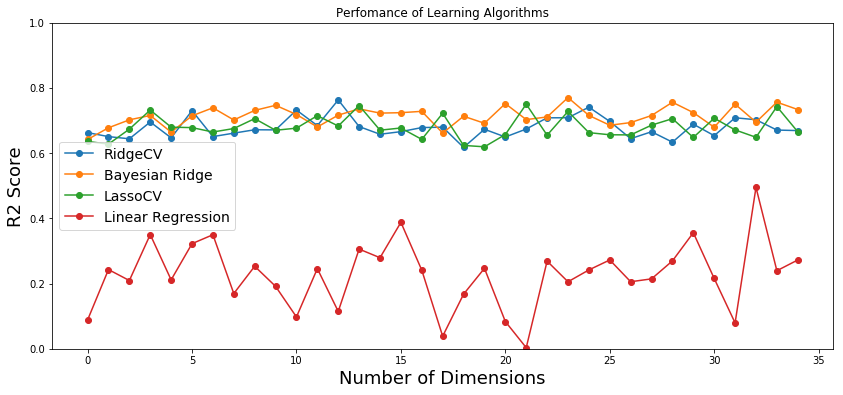

In [420]:

results_df = pd.DataFrame(all_results, columns=type_, index=number_of_coef)
plt.figure(figsize=(14,6))
plt.plot([(row["RidgeCV"], row["Bayesian Ridge"], row["LassoCV"], row["Linear Regression"]
          ) for index, row in results_df.iterrows()], 'o-')
plt.ylim(0,1)
plt.xlabel('Number of Dimensions', fontsize=18)
plt.ylabel('R2 Score', fontsize=18)
plt.title('Perfomance of Learning Algorithms')
plt.legend(['RidgeCV', 'Bayesian Ridge', 'LassoCV', 'Linear Regression'], fontsize=14, loc='upperleft')
plt.show()

In [421]:
results_df[results_df[best_fit] == results_df[best_fit].max()]

,RidgeCV,Bayesian Ridge,LassoCV,Linear Regression
87,0.708401,0.770214,0.727787,0.205522


In [422]:
best_number_of_variables = results_df[results_df[best_fit] == results_df[best_fit].max()].index[0]
X_train_best_coef = X_train[coefs_sorted.index[:best_number_of_variables]]
X_test_best_coef = X_test[coefs_sorted.index[:best_number_of_variables]]
#fm = linear_model.LinearRegression()
if(best_fit == "RidgeCV"):
    fm = linear_model.RidgeCV()
elif(best_fit == "Bayesian Ridge"):
    fm = linear_model.BayesianRidge()
elif(best_fit == "LassoCV"):
    fm = linear_model.LassoCV()
elif(best_fit == "Linear Regression"):
    fm = linear_model.LinearRegression()
#fm = linear_model.BayesianRidge()     
fm.fit(X_train_best_coef, y_train)

y_pred = fm.predict(X_test_best_coef)
print('R2 is for best model '+best_fit+" is :")
r2_score(y_test, y_pred)

R2 is for best model Bayesian Ridge is :


0.713884853990507

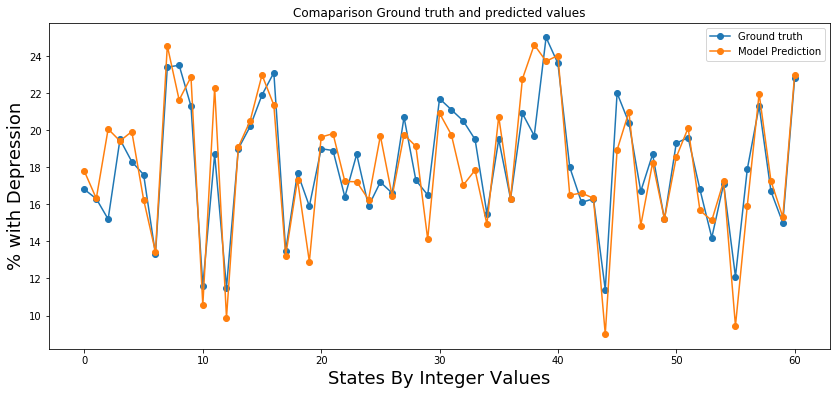

In [423]:
#plots of ground truth against the predictions
plt.figure(figsize=(14,6))
plt.plot(y_test, "o-")
plt.plot(y_pred, "o-")
plt.legend(["Ground truth", "Model Prediction"])
plt.xlabel('States By Integer Values', fontsize=18)
plt.ylabel('% with Depression', fontsize=18)
plt.title('Comaparison Ground truth and predicted values')
plt.show()